In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nb

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torchvision.transforms as transforms

In [ ]:
BASE_DIR="/content/drive/MyDrive/dataset/Brain_vishal/extract_data/imaging dataset"
#TRAIN_IMAGES_DIR=os.path.join(BASE_DIR,'train_images')

data_df=pd.read_excel('/content/drive/MyDrive/dataset/Brain_vishal/extract_data/Classification_clean.xlsx')
data_df["Class"]=data_df["Diagnosis"]>0
#data_df["Class"].replace(True,2,inplace=True)
#data_df["Class"].replace(False,1,inplace=True)
data_df.Class = data_df.Class.astype('int')


data_df.head()

In [ ]:
class Milano_MRI_Dataset(Dataset):
    def __init__(self,df:pd.DataFrame,imfolder:str,train:bool = True, transforms=None):
        self.df=df
        self.imfolder=imfolder
        self.train=train
        #self.transforms=transforms

    def __getitem__(self,index):
        filename='w'+self.df.iloc[index]['ID_CF']+'_MRI_sMRI_'+self.df.iloc[index]['ID_CF']+'_brain.nii.gz';

        im_path=os.path.join(self.imfolder,filename)

        nimg = nb.load(im_path)
        x = np.array(nimg.dataobj)
        #x=nimg.get_fdata()
        x = transforms.ToTensor()(x)
        x=x.unsqueeze(0).type(torch.FloatTensor);
        m=torch.mean(x)
        s=torch.std(x)
        x=(x-m)/s
        #if(self.transforms):
        #    x=self.transforms(image=x)['image']

        if(self.train):
            y=self.df.iloc[index]['Class']
            return x,y
        else:
            return x

    def __len__(self):
        return len(self.df)




In [ ]:
train, valid = train_test_split(
    data_df,
    test_size=0.2,
    random_state=42,
    stratify=data_df.Class.values
)



# reset index on both dataframes
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)

train_targets = train.Class.values

# targets for validation
valid_targets = valid.Class.values

train_dataset=Milano_MRI_Dataset(
    df=train,
    imfolder=BASE_DIR,
    train=True,
    transforms=None
)

valid_dataset=Milano_MRI_Dataset(
    df=valid,
    imfolder=BASE_DIR,
    train=True,
    transforms=None
)

train_loader = DataLoader(
    train_dataset,
    batch_size=15,
    #num_workers=4,
    shuffle=True,
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=15,
    #num_workers=4,
    shuffle=False,
)

# A simple 3D CNN

In [ ]:
import torch
import torch.nn as nn
import math
from functools import partial
from torch.autograd import Variable

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

import time
import datetime
import copy

In [ ]:
class Simple3DCNN(nn.Module):

    def __init__(self, num_classes):


        super(Simple3DCNN, self).__init__()

        self.conv_layer1 = self._make_conv_layer(1, 32)
        self.conv_layer2 = self._make_conv_layer(32, 64)
        self.conv_layer3 = self._make_conv_layer(64, 128)
        self.conv_layer4 = self._make_conv_layer(128, 256)
        self.conv_layer5=nn.Conv3d(256, 2048, kernel_size=(4, 4, 5), padding=0)

        self.fc5 = nn.Linear(2048, 512)
        self.relu = nn.LeakyReLU()
        self.batch0=nn.BatchNorm1d(512)
        self.drop=nn.Dropout(p=0.25)
        self.fc6 = nn.Linear(512, 256)
        self.relu = nn.LeakyReLU()
        self.batch1=nn.BatchNorm1d(256)

        self.drop=nn.Dropout(p=0.25)
        self.fc7 = nn.Linear(256, num_classes)

    def _make_conv_layer(self, in_c, out_c):
        conv_layer = nn.Sequential(
        nn.Conv3d(in_c, out_c, kernel_size=3, padding=1),
        nn.LeakyReLU(),
        #nn.Conv3d(out_c, out_c, kernel_size=3, padding=1),
        #nn.LeakyReLU(),
        nn.BatchNorm3d(out_c),
        nn.MaxPool3d(kernel_size=2, stride=2),
        )
        return conv_layer

    def forward(self, x):
        #print(x.size())
        x = self.conv_layer1(x)
        #print(x.size())
        x = self.conv_layer2(x)
        #print(x.size())
        x = self.conv_layer3(x)
        #print(x.size())
        x = self.conv_layer4(x)
        #print(x.size())
        x=self.conv_layer5(x)
        #print(x.size())
        x = x.view(x.size(0), -1)
        #print(x.size())
        x = self.fc5(x)
        x = self.relu(x)
        #print(x.size())
        x = self.batch0(x)
        x = self.drop(x)
        x = self.fc6(x)
        x = self.relu(x)
        x = self.batch1(x)
        x = self.drop(x)
        x = self.fc7(x)

        return x#,x1

In [ ]:
model = Simple3DCNN(2)

In [ ]:
tmp=next(iter(train_loader))
out=model(tmp[0])

In [ ]:
# import zipfile

# # Specify the path to the zip file and the extraction directory
# zip_file_path = "/content/drive/MyDrive/dataset/Brain_vishal/OneDrive_2024-12-01.zip"
# extract_to_path = "/content/drive/MyDrive/dataset/Brain_vishal/extract_data"

# # Open the zip file
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     # Extract all the contents
#     zip_ref.extractall(extract_to_path)

# print(f"Extracted all files to {extract_to_path}")


# Defining the training function

In [ ]:
def train_model(datasets, dataloaders, model, criterion, optimizer, scheduler, num_epochs, device):

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels=labels.to(device)

                # Zero out the grads
                optimizer.zero_grad()

                # Forward
                # Track history in train mode
                with torch.set_grad_enabled(phase == 'train'):
                    model=model.to(device)
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    #loss = criterion(outputs, labels.type(torch.LongTensor).unsqueeze(1).to(device))
                    loss = criterion(outputs, labels.type(torch.LongTensor).to(device))

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # Statistics
                running_loss += loss.item()*inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss/len(datasets[phase])
            epoch_acc = running_corrects.double()/len(datasets[phase])

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time()-since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

# Training

In [ ]:
class_sample_count = np.array([len(np.where(train_targets == t)[0]) for t in np.unique(train_targets)])
weight = 1. / class_sample_count
class_weight=torch.from_numpy(weight)
class_weight=class_weight.max()/class_weight
class_weight=class_weight/class_weight.max()
class_weight=class_weight.type(torch.FloatTensor)
print(class_weight)

tensor([1.0000, 0.4944])


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

datasets={'train':train_dataset,'valid':valid_dataset}
dataloaders={'train':train_loader,'valid':valid_loader}

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-6, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

criterion=nn.CrossEntropyLoss()
#criterion=nn.BCEWithLogitsLoss()

num_epochs=100

trained_model=train_model(datasets,dataloaders,model,criterion,optimizer,scheduler,num_epochs,device)


Epoch 0/99
----------
train Loss: 0.7391 Acc: 0.5725
valid Loss: 0.6892 Acc: 0.5333

Epoch 1/99
----------
train Loss: 0.6755 Acc: 0.6004
valid Loss: 0.6847 Acc: 0.5852

Epoch 2/99
----------
train Loss: 0.6460 Acc: 0.6487
valid Loss: 0.7154 Acc: 0.5556

Epoch 3/99
----------
train Loss: 0.6083 Acc: 0.6710
valid Loss: 0.6887 Acc: 0.5778

Epoch 4/99
----------
train Loss: 0.5740 Acc: 0.6803
valid Loss: 0.6928 Acc: 0.5926

Epoch 5/99
----------
train Loss: 0.5494 Acc: 0.7230
valid Loss: 0.6566 Acc: 0.6222

Epoch 6/99
----------
train Loss: 0.5198 Acc: 0.7528
valid Loss: 0.7024 Acc: 0.5852

Epoch 7/99
----------
train Loss: 0.4931 Acc: 0.7454
valid Loss: 0.7140 Acc: 0.6148

Epoch 8/99
----------
train Loss: 0.4779 Acc: 0.7770
valid Loss: 0.6617 Acc: 0.6074

Epoch 9/99
----------
train Loss: 0.4281 Acc: 0.8383
valid Loss: 0.6761 Acc: 0.5926

Epoch 10/99
----------
train Loss: 0.4641 Acc: 0.7844
valid Loss: 0.6670 Acc: 0.6444

Epoch 11/99
----------
train Loss: 0.4151 Acc: 0.8253
valid Loss

# *VGG16*

In [ ]:
BASE_DIR="/content/drive/MyDrive/imaging dataset"
data_df = pd.read_excel('/content/drive/MyDrive/Classification_clean.xlsx')


Epoch 0/9
----------
train Loss: 0.6781 Acc: 0.6245
valid Loss: 0.6017 Acc: 0.6741

Epoch 1/9
----------
train Loss: 0.6464 Acc: 0.6580
valid Loss: 0.5978 Acc: 0.6741

Epoch 2/9
----------
train Loss: 0.6241 Acc: 0.6431
valid Loss: 0.5958 Acc: 0.6741

Epoch 3/9
----------
train Loss: 0.6295 Acc: 0.6691
valid Loss: 0.5925 Acc: 0.6741

Epoch 4/9
----------
train Loss: 0.6162 Acc: 0.6877
valid Loss: 0.5891 Acc: 0.6667

Epoch 5/9
----------
train Loss: 0.6132 Acc: 0.6673
valid Loss: 0.5863 Acc: 0.6741

Epoch 6/9
----------
train Loss: 0.6132 Acc: 0.6803
valid Loss: 0.5851 Acc: 0.6741

Epoch 7/9
----------
train Loss: 0.6033 Acc: 0.6524
valid Loss: 0.5832 Acc: 0.6741

Epoch 8/9
----------
train Loss: 0.5918 Acc: 0.6877
valid Loss: 0.5811 Acc: 0.6741

Epoch 9/9
----------
train Loss: 0.5821 Acc: 0.6896
valid Loss: 0.5782 Acc: 0.6741

Training complete in 6m 10s
Best val Acc: 0.6741
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.67      1.00

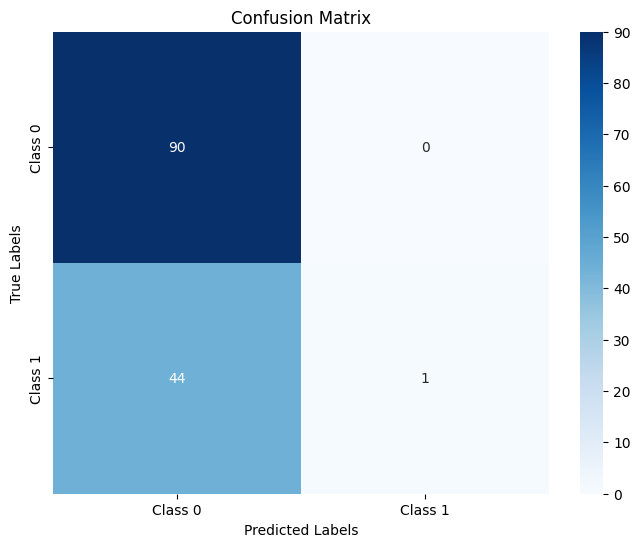

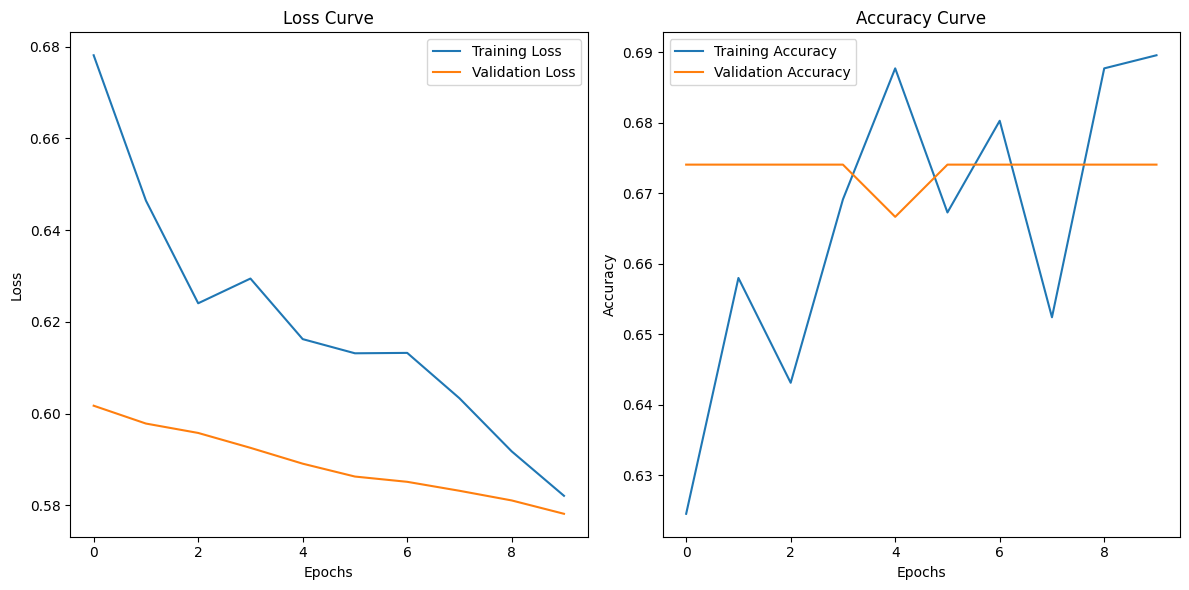

In [ ]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import pandas as pd
import numpy as np
import nibabel as nb
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import time
import copy
import matplotlib.pyplot as plt
import seaborn as sns

# VGG16 model setup (pre-trained)
class VGG16_Classifier(nn.Module):
    def __init__(self, num_classes=2):
        super(VGG16_Classifier, self).__init__()
        # Load the pre-trained VGG16 model
        self.vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
        # Modify the classifier to match the number of output classes
        self.vgg16.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)

    def forward(self, x):
        return self.vgg16(x)

# Dataset class
class Milano_MRI_Dataset(Dataset):
    def __init__(self, df: pd.DataFrame, imfolder: str, train: bool = True, custom_transforms=None):
        self.df = df
        self.imfolder = imfolder
        self.train = train
        self.transforms = custom_transforms if custom_transforms else transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),  # Resize to fit VGG16 input size
            transforms.Lambda(lambda x: np.stack([x, x, x], axis=-1)),  # Expand to 3 channels
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # VGG16 normalization
        ])

    def __getitem__(self, index):
        filename = f"w{self.df.iloc[index]['ID_CF']}_MRI_sMRI_{self.df.iloc[index]['ID_CF']}_brain.nii.gz"
        im_path = os.path.join(self.imfolder, filename)

        # Load MRI scan
        nimg = nb.load(im_path)
        x = np.array(nimg.dataobj)

        # Convert 3D MRI scan to 2D slice (middle slice)
        x = x[:, :, x.shape[2] // 2]  # Middle slice of the 3D volume

        # Apply transformations
        x = self.transforms(x)

        if self.train:
            y = self.df.iloc[index]['Class']
            return x, y
        else:
            return x

    def __len__(self):
        return len(self.df)

# Training function
def train_model(datasets, dataloaders, model, criterion, optimizer, scheduler, num_epochs, device):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # For tracking history
    history = {'train_loss': [], 'valid_loss': [], 'train_acc': [], 'valid_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(datasets[phase])
            epoch_acc = running_corrects.double() / len(datasets[phase])

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model, history

# Evaluation function
def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_labels), np.array(all_preds)

# Plotting function for confusion matrix and curves
def plot_confusion_matrix(labels, preds):
    conf_matrix = confusion_matrix(labels, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

def plot_training_curves(history):
    epochs = len(history['train_loss'])
    plt.figure(figsize=(12, 6))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), history['train_loss'], label='Training Loss')
    plt.plot(range(epochs), history['valid_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curve')

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), history['train_acc'], label='Training Accuracy')
    plt.plot(range(epochs), history['valid_acc'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Curve')

    plt.tight_layout()
    plt.show()

# After training the model
datasets = {'train': train_dataset, 'valid': valid_dataset}
dataloaders = {'train': train_loader, 'valid': valid_loader}

num_epochs = 10
trained_model, history = train_model(datasets, dataloaders, model, criterion, optimizer, scheduler, num_epochs, device)

# Evaluate on validation set
val_labels, val_preds = evaluate_model(trained_model, valid_loader, device)

# Print performance metrics
print("Classification Report:")
print(classification_report(val_labels, val_preds, target_names=['Class 0', 'Class 1']))
accuracy = accuracy_score(val_labels, val_preds)
print(f"Validation Accuracy: {accuracy:.4f}")

# Plot confusion matrix
plot_confusion_matrix(val_labels, val_preds)

# Plot training and validation curves
plot_training_curves(history)


# ResNet18

In [ ]:
# ResNet-18 model setup (pre-trained)
class ResNet18_Classifier(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet18_Classifier, self).__init__()
        # Load the pre-trained ResNet-18 model
        self.resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        # Modify the final fully connected layer to match the number of output classes
        self.resnet18.fc = nn.Linear(in_features=self.resnet18.fc.in_features, out_features=num_classes)

    def forward(self, x):
        return self.resnet18(x)


In [ ]:
model = ResNet18_Classifier(num_classes=2).to(device)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 110MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [ ]:
trained_model, history = train_model(datasets, dataloaders, model, criterion, optimizer, scheduler, num_epochs, device)


Epoch 0/9
----------
train Loss: 0.7374 Acc: 0.6394
valid Loss: 0.6134 Acc: 0.6963

Epoch 1/9
----------
train Loss: 0.6114 Acc: 0.6803
valid Loss: 0.5931 Acc: 0.6667

Epoch 2/9
----------
train Loss: 0.5874 Acc: 0.6896
valid Loss: 0.7597 Acc: 0.4741

Epoch 3/9
----------
train Loss: 0.5474 Acc: 0.7658
valid Loss: 1.1264 Acc: 0.6667

Epoch 4/9
----------
train Loss: 0.4822 Acc: 0.7751
valid Loss: 0.7325 Acc: 0.5259

Epoch 5/9
----------
train Loss: 0.3549 Acc: 0.8476
valid Loss: 1.3819 Acc: 0.4370

Epoch 6/9
----------
train Loss: 0.2889 Acc: 0.8773
valid Loss: 1.2364 Acc: 0.6667

Epoch 7/9
----------
train Loss: 0.1661 Acc: 0.9387
valid Loss: 0.7496 Acc: 0.7037

Epoch 8/9
----------
train Loss: 0.0604 Acc: 0.9926
valid Loss: 0.8105 Acc: 0.6667

Epoch 9/9
----------
train Loss: 0.0472 Acc: 0.9944
valid Loss: 0.8842 Acc: 0.6815

Training complete in 3m 16s
Best val Acc: 0.7037


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.75      0.84      0.79        90
     Class 1       0.58      0.42      0.49        45

    accuracy                           0.70       135
   macro avg       0.66      0.63      0.64       135
weighted avg       0.69      0.70      0.69       135

Validation Accuracy: 0.7037


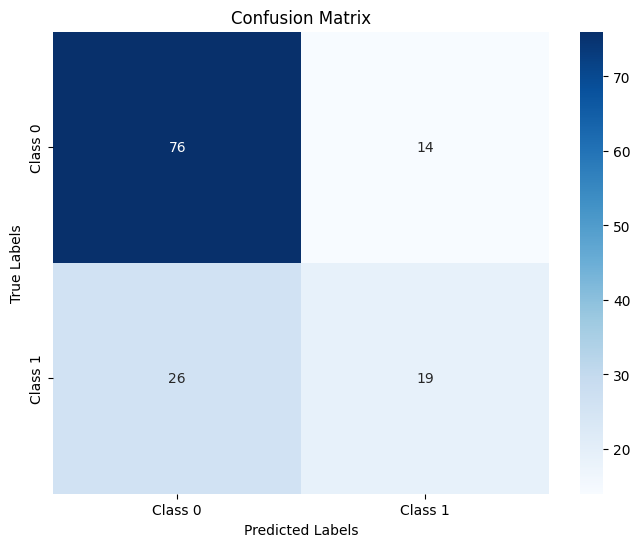

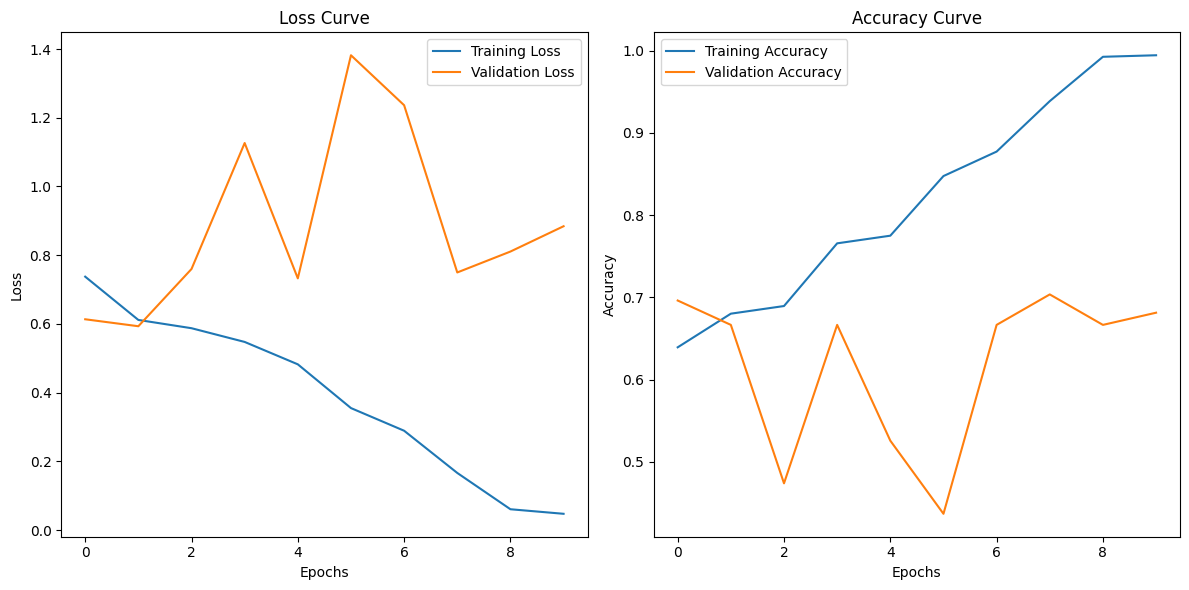

In [ ]:
# Evaluate on validation set
val_labels, val_preds = evaluate_model(trained_model, valid_loader, device)

# Print performance metrics
print("Classification Report:")
print(classification_report(val_labels, val_preds, target_names=['Class 0', 'Class 1']))
accuracy = accuracy_score(val_labels, val_preds)
print(f"Validation Accuracy: {accuracy:.4f}")

# Plot confusion matrix
plot_confusion_matrix(val_labels, val_preds)

# Plot training and validation curves
plot_training_curves(history)


# DenseNet121

In [ ]:
# DenseNet-121 model setup (pre-trained)
class DenseNet121_Classifier(nn.Module):
    def __init__(self, num_classes=2):
        super(DenseNet121_Classifier, self).__init__()
        # Load the pre-trained DenseNet-121 model
        self.densenet121 = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
        # Modify the classifier (final fully connected layer)
        self.densenet121.classifier = nn.Linear(in_features=self.densenet121.classifier.in_features, out_features=num_classes)

    def forward(self, x):
        return self.densenet121(x)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


Epoch 0/9
----------
train Loss: 0.7000 Acc: 0.6320
valid Loss: 0.7873 Acc: 0.6667

Epoch 1/9
----------
train Loss: 0.6267 Acc: 0.6375
valid Loss: 0.5590 Acc: 0.6889

Epoch 2/9
----------
train Loss: 0.5687 Acc: 0.6859
valid Loss: 0.6017 Acc: 0.6963

Epoch 3/9
----------
train Loss: 0.5177 Acc: 0.7045
valid Loss: 0.6069 Acc: 0.6741

Epoch 4/9
----------
train Loss: 0.5254 Acc: 0.7323
valid Loss: 1.0546 Acc: 0.6667

Epoch 5/9
----------
train Loss: 0.5556 Acc: 0.7342
valid Loss: 1.3848 Acc: 0.6963

Epoch 6/9
----------
train Loss: 0.6053 Acc: 0.6933
valid Loss: 0.8490 Acc: 0.6667

Epoch 7/9
----------
train Loss: 0.5063 Acc: 0.7230
valid Loss: 0.5220 Acc: 0.6963

Epoch 8/9
----------
train Loss: 0.4311 Acc: 0.8123
valid Loss: 0.5144 Acc: 0.7481

Epoch 9/9
----------
train Loss: 0.3410 Acc: 0.8717
valid Loss: 0.5529 Acc: 0.6889

Training complete in 3m 40s
Best val Acc: 0.7481
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.79      0.86

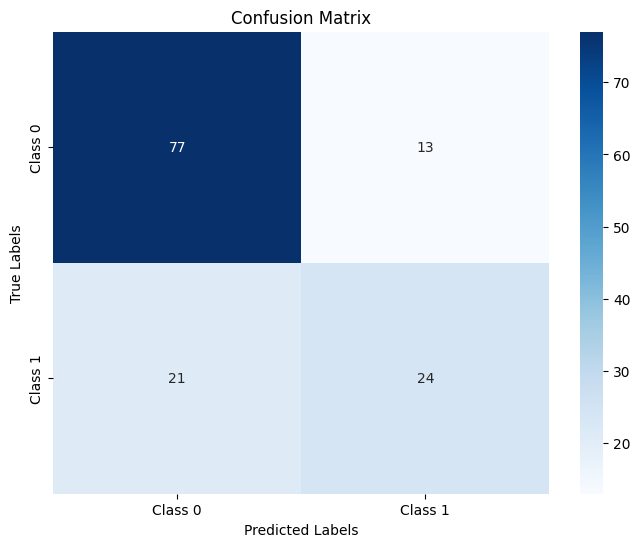

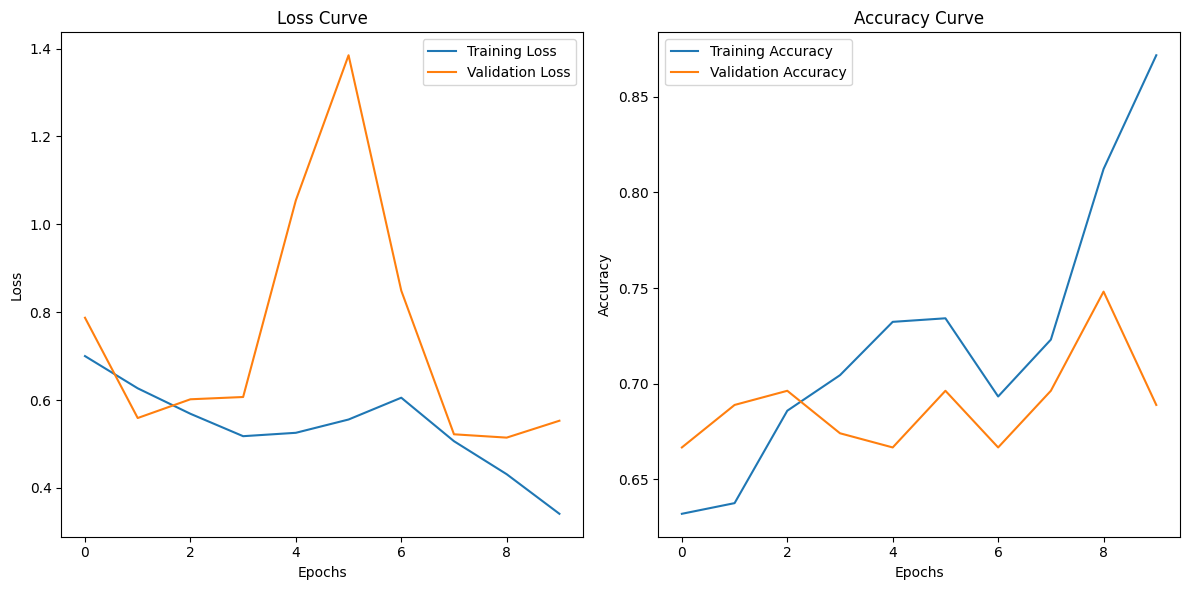

Epoch 0/9
----------
train Loss: 0.6723 Acc: 0.6468
valid Loss: 0.5802 Acc: 0.6741

Epoch 1/9
----------
train Loss: 0.6068 Acc: 0.6859
valid Loss: 0.5755 Acc: 0.7259

Epoch 2/9
----------
train Loss: 0.5765 Acc: 0.6914
valid Loss: 0.6590 Acc: 0.6667

Epoch 3/9
----------
train Loss: 0.5631 Acc: 0.6952
valid Loss: 0.8407 Acc: 0.6667

Epoch 4/9
----------
train Loss: 0.5874 Acc: 0.6710
valid Loss: 0.5780 Acc: 0.7037

Epoch 5/9
----------
train Loss: 0.5438 Acc: 0.7063
valid Loss: 0.7016 Acc: 0.6963

Epoch 6/9
----------
train Loss: 0.5560 Acc: 0.7156
valid Loss: 0.6986 Acc: 0.6222

Epoch 7/9
----------
train Loss: 0.4577 Acc: 0.7918
valid Loss: 0.5709 Acc: 0.7037

Epoch 8/9
----------
train Loss: 0.3564 Acc: 0.8439
valid Loss: 0.6345 Acc: 0.6370

Epoch 9/9
----------
train Loss: 0.2595 Acc: 0.9108
valid Loss: 0.6563 Acc: 0.6519

Training complete in 3m 27s
Best val Acc: 0.7259
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.72      0.98

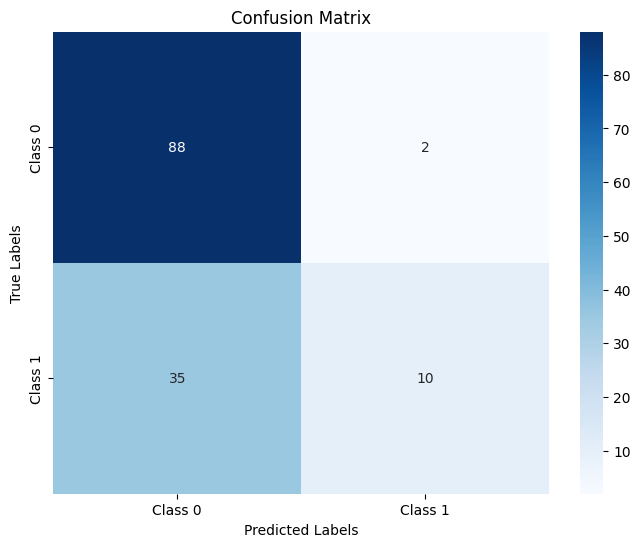

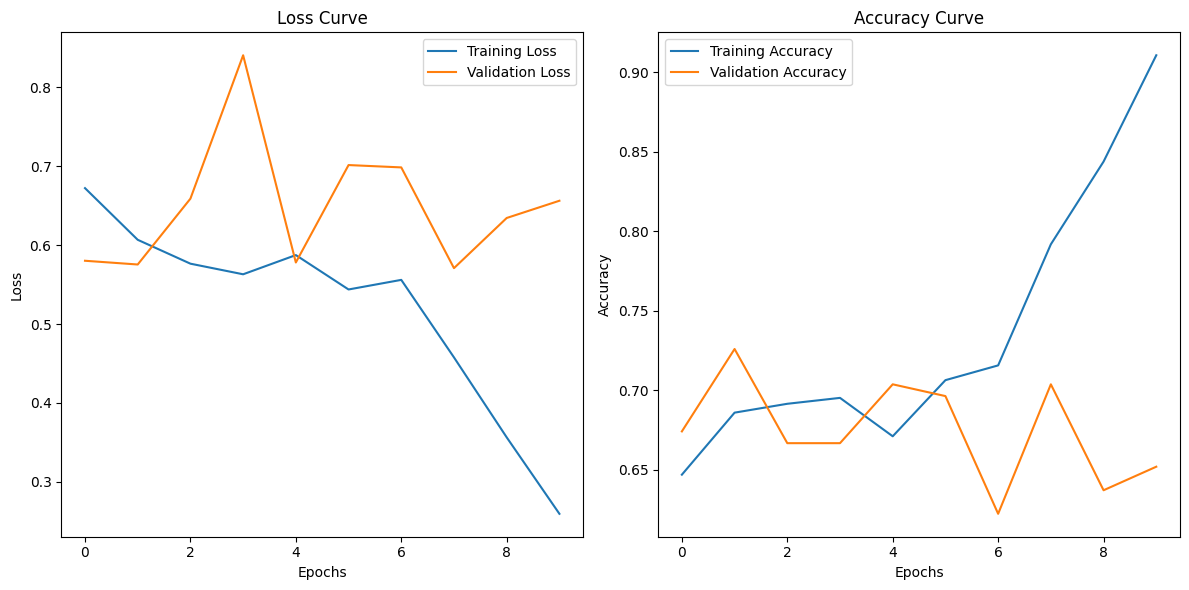

In [ ]:
# Initialize DenseNet-121 model
model = DenseNet121_Classifier(num_classes=2).to(device)

# Define criterion, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Train the model
num_epochs = 10
trained_model, history = train_model(datasets, dataloaders, model, criterion, optimizer, scheduler, num_epochs, device)

# Evaluate on validation set
val_labels, val_preds = evaluate_model(trained_model, valid_loader, device)

# Print performance metrics
print("Classification Report:")
print(classification_report(val_labels, val_preds, target_names=['Class 0', 'Class 1']))
accuracy = accuracy_score(val_labels, val_preds)
print(f"Validation Accuracy: {accuracy:.4f}")

# Plot confusion matrix
plot_confusion_matrix(val_labels, val_preds)

# Plot training and validation curves
plot_training_curves(history)
